# NOTEBOOK 6: MATRIX FACTORIZATION (SVD)
## Latent Factor Models for Recommendations

This notebook implements matrix factorization using Singular Value Decomposition (SVD) to uncover latent features in the user-item interaction matrix.
It includes training SVD models with different dimensions, generating recommendations, evaluating performance, visualizing the latent space, and comparing results with content-based and collaborative filtering methods.

## 1. SETUP & CONFIGURATION

In [9]:

# IMPORT LIBRARIES

print("=" * 80)
print("SETUP: IMPORTING LIBRARIES")
print("=" * 80)


import numpy as np              
import pandas as pd            
import matplotlib.pyplot as plt 
import seaborn as sns          
import pickle                
import os                     
import time                    
from datetime import datetime  

# Sparse matrix operations
from scipy.sparse import csr_matrix, load_npz  

# Machine Learning
from sklearn.decomposition import TruncatedSVD  
from sklearn.preprocessing import normalize     
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully")

 
# VISUALIZATION SETTINGS


# Set consistent, professional plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Default figure settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print(" Plot settings configured")


# DIRECTORY STRUCTURE 

print("\n" + "=" * 80)
print("DIRECTORY SETUP")
print("=" * 80)


import sys
PROJECT_ROOT = os.path.dirname(os.getcwd())  

print(f" Current directory: {os.getcwd()}")
print(f" Project root: {PROJECT_ROOT}")

# Define project directories relative to PROJECT_ROOT
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PROCESSED_DIR = os.path.join(PROJECT_ROOT, 'data', 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'reports', 'results')

# Create directories if they don't exist
for directory in [MODELS_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)
    
print(f"\n Directory structure:")
print(f"   • Data: {DATA_DIR}")
print(f"   • Processed: {PROCESSED_DIR}")
print(f"   • Models: {MODELS_DIR}")
print(f"   • Results: {RESULTS_DIR}")

# Verify directories exist
all_exist = all(os.path.exists(d) for d in [DATA_DIR, MODELS_DIR])
if all_exist:
    print(f" All directories ready")
else:
    print(f"  Some directories missing - will try to continue")

# LOAD PREVIOUS RESULTS


print("\n" + "=" * 80)
print("LOADING DATA FROM PREVIOUS NOTEBOOKS")
print("=" * 80)

# Load User-Item Matrix

print("\n Loading user-item interaction matrix...")

matrix_path = os.path.join(MODELS_DIR, 'user_item_matrix.npz')

print(f"   Looking for: {matrix_path}")

# Check if file exists
if not os.path.exists(matrix_path):
    print(f"    Matrix not found!")
    print(f"\n  SOLUTION: We need to generate the matrix from Notebook 5 data")
    print(f"   I'll help you create it now...\n")
    
    # Try to load from training data
    train_path = os.path.join(DATA_DIR, 'ratings_train.csv')
    
    if os.path.exists(train_path):
        print("   ✅ Found training data - will regenerate matrix")
        print("   This will take a few minutes...")
        
        # Load training data
        train = pd.read_csv(train_path)
        print(f"   Loaded: {len(train):,} training ratings")
        
        # Create mappings
        unique_users = train['userId'].unique()
        unique_movies = train['movieId'].unique()
        
        user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
        idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
        movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}
        idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}
        
        print(f"   Created mappings: {len(user_to_idx):,} users, {len(movie_to_idx):,} movies")
        
        # Build matrix
        n_users = len(user_to_idx)
        n_movies = len(movie_to_idx)
        
        user_indices = train['userId'].map(user_to_idx).values
        movie_indices = train['movieId'].map(movie_to_idx).values
        ratings = train['rating'].values
        
        user_item_matrix = csr_matrix(
            (ratings, (user_indices, movie_indices)),
            shape=(n_users, n_movies)
        )
        
        print(f"   Matrix created: {user_item_matrix.shape}")
        
        # Save for next time
        from scipy.sparse import save_npz
        save_npz(matrix_path, user_item_matrix)
        print(f"    Saved matrix for future use")
        
        # Save mappings
        mappings = {
            'user_to_idx': user_to_idx,
            'idx_to_user': idx_to_user,
            'movie_to_idx': movie_to_idx,
            'idx_to_movie': idx_to_movie
        }
        mappings_path = os.path.join(MODELS_DIR, 'matrix_mappings.pkl')
        with open(mappings_path, 'wb') as f:
            pickle.dump(mappings, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"    Saved mappings for future use")
        
    else:
        raise FileNotFoundError(
            f"Cannot find training data at {train_path}. "
            "Please ensure Notebook 5 has been run and data files exist."
        )
else:
    # Load existing matrix
    user_item_matrix = load_npz(matrix_path)
    print(f"    Matrix loaded from file")

# Calculate sparsity
sparsity = (1 - user_item_matrix.nnz / 
            (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100

print(f"\n Matrix ready:")
print(f"   Shape: {user_item_matrix.shape[0]:,} users × "
      f"{user_item_matrix.shape[1]:,} movies")
print(f"   Non-zero entries: {user_item_matrix.nnz:,}")
print(f"   Sparsity: {sparsity:.2f}%")
print(f"   Memory: {user_item_matrix.data.nbytes / (1024**2):.1f} MB")

#
# Load ID Mappings

print("\n  Loading user/movie ID mappings...")

mappings_path = os.path.join(MODELS_DIR, 'matrix_mappings.pkl')

if not os.path.exists(mappings_path):
    print(f"     Mappings not found - using ones created above")
    # Already created above when regenerating matrix
else:
    with open(mappings_path, 'rb') as f:
        mappings = pickle.load(f)
        user_to_idx = mappings['user_to_idx']
        idx_to_user = mappings['idx_to_user']
        movie_to_idx = mappings['movie_to_idx']
        idx_to_movie = mappings['idx_to_movie']
    print(f"    Mappings loaded from file")

print(f"   Users: {len(user_to_idx):,}")
print(f"   Movies: {len(movie_to_idx):,}")

# Load Evaluation Setup 

print("\n Loading evaluation setup...")

cf_results_path = os.path.join(MODELS_DIR, 'evaluation_results_cf.pkl')

if os.path.exists(cf_results_path):
    with open(cf_results_path, 'rb') as f:
        cf_results = pickle.load(f)
        eval_user_ids = cf_results['eval_user_ids']
        ground_truth = cf_results['ground_truth']
        ub_metrics = cf_results['user_based_metrics']
        ib_metrics = cf_results['item_based_metrics']
    
    print(f" Evaluation setup loaded:")
    print(f"   Evaluation users: {len(eval_user_ids)}")
    print(f"   Ground truth available: {len(ground_truth)} users")
    
    print(f"\n Previous CF Results (for comparison):")
    print(f"   User-Based CF:")
    print(f"      • Precision@10: {ub_metrics['Precision@10']:.2f}%")
    print(f"      • Hit Rate@10:  {ub_metrics['Hit Rate@10']:.2f}%")
    print(f"   Item-Based CF:")
    print(f"      • Precision@10: {ib_metrics['Precision@10']:.2f}%")
    print(f"      • Hit Rate@10:  {ib_metrics['Hit Rate@10']:.2f}%")
else:
    print(f"     CF results not found")
    print(f"   We'll create evaluation setup from test data...")
    
    # Load test data
    test_path = os.path.join(DATA_DIR, 'ratings_test.csv')
    if os.path.exists(test_path):
        test = pd.read_csv(test_path)
        
        # Sample 100 users who exist in training
        test_users = test[test['userId'].isin(user_to_idx.keys())]['userId'].unique()
        np.random.seed(42)
        eval_user_ids = np.random.choice(test_users, size=min(100, len(test_users)), replace=False)
        
        # Create ground truth
        ground_truth = {}
        for user_id in eval_user_ids:
            user_test = test[test['userId'] == user_id]
            relevant = user_test[user_test['rating'] >= 4.0]['movieId'].tolist()
            ground_truth[user_id] = relevant
        
        print(f"    Created evaluation setup: {len(eval_user_ids)} users")
        
        # No previous CF metrics
        ub_metrics = None
        ib_metrics = None
    else:
        print(f"    Cannot create evaluation - test data not found")
        eval_user_ids = []
        ground_truth = {}
        ub_metrics = None
        ib_metrics = None


# Load Movies Data

print("\n Loading movies data...")

movies_path = os.path.join(PROCESSED_DIR, 'movies_features.csv')
if not os.path.exists(movies_path):
    movies_path = os.path.join(DATA_DIR, 'movies_filtered.csv')
if not os.path.exists(movies_path):
    movies_path = os.path.join(DATA_DIR, 'movies.csv')

if os.path.exists(movies_path):
    movies = pd.read_csv(movies_path)
    print(f" Movies loaded: {len(movies):,} movies")
else:
    print(f"  Movies file not found - will work without titles")
    movies = None



SETUP: IMPORTING LIBRARIES
 All libraries imported successfully
 Plot settings configured

DIRECTORY SETUP
 Current directory: c:\Users\mhfou\Documents\MovieRecommenderSystem\notebooks
 Project root: c:\Users\mhfou\Documents\MovieRecommenderSystem

 Directory structure:
   • Data: c:\Users\mhfou\Documents\MovieRecommenderSystem\data
   • Processed: c:\Users\mhfou\Documents\MovieRecommenderSystem\data\processed
   • Models: c:\Users\mhfou\Documents\MovieRecommenderSystem\models
   • Results: c:\Users\mhfou\Documents\MovieRecommenderSystem\reports\results
 All directories ready

LOADING DATA FROM PREVIOUS NOTEBOOKS

 Loading user-item interaction matrix...
   Looking for: c:\Users\mhfou\Documents\MovieRecommenderSystem\models\user_item_matrix.npz
    Matrix loaded from file

 Matrix ready:
   Shape: 137,883 users × 34,461 movies
   Non-zero entries: 20,000,076
   Sparsity: 99.58%
   Memory: 152.6 MB

  Loading user/movie ID mappings...
    Mappings loaded from file
   Users: 137,883
   M

## 2: DATA NORMALIZATION FOR SVD



In [14]:


print("\n" + "=" * 80)
print(" NORMALIZE USER-ITEM MATRIX")
print("=" * 80)


# Compute User Rating Means 

print("-" * 80)
print("Step 1: Computing user rating averages (only from rated movies)")
print("-" * 80)

# Calculate mean rating for each user
# CRITICAL: Only average over RATED movies, not all movies!
user_means = np.zeros(user_item_matrix.shape[0])

for user_idx in range(user_item_matrix.shape[0]):
    # Get user's ratings (only non-zero)
    user_ratings = user_item_matrix.getrow(user_idx).data
    
    # Calculate mean only from rated movies
    if len(user_ratings) > 0:
        user_means[user_idx] = user_ratings.mean()
    else:
        user_means[user_idx] = 0  # Users with no ratings (shouldn't happen)
    
    # Progress indicator
    if (user_idx + 1) % 20000 == 0:
        print(f"   Computed means for {user_idx + 1:,} / {user_item_matrix.shape[0]:,} users...")

print(f"\n Computed means for {len(user_means):,} users")
print(f"   Mean of means: {user_means.mean():.2f}")
print(f"   Std of means:  {user_means.std():.2f}")
print(f"   Min mean:      {user_means.min():.2f} (harsh critic)")
print(f"   Max mean:      {user_means.max():.2f} (generous rater)")

# Center the Matrix

print("\n" + "-" * 80)
print("Step 2: Centering ratings (subtract user means)")
print("-" * 80)

# Create centered matrix by subtracting user means
n_users, n_movies = user_item_matrix.shape

data_centered = []
indices_centered = []
indptr_centered = [0]

print("   Centering in progress...")
for user_idx in range(n_users):
    # Get user's ratings (sparse row)
    user_row = user_item_matrix.getrow(user_idx)
    
    # Get non-zero indices and values
    _, movie_indices = user_row.nonzero()
    ratings = user_row.data
    
    # Center the ratings: subtract this user's mean
    centered_ratings = ratings - user_means[user_idx]
    
    # Store in new sparse format
    data_centered.extend(centered_ratings)
    indices_centered.extend(movie_indices)
    indptr_centered.append(len(data_centered))
    
    # Progress indicator
    if (user_idx + 1) % 20000 == 0:
        print(f"   Processed {user_idx + 1:,} / {n_users:,} users...")

# Create centered sparse matrix
user_item_matrix_centered = csr_matrix(
    (data_centered, indices_centered, indptr_centered),
    shape=(n_users, n_movies)
)

print(f"\n Matrix centered successfully")
print(f"   New mean rating: {np.array(data_centered).mean():.6f}★ (should be ≈0)")
print(f"   New std rating:  {np.array(data_centered).std():.2f}★")


# Verify Centering

print("\n" + "-" * 80)
print("Step 3: Verification")
print("-" * 80)

# Check a sample user who has many ratings
sample_user_idx = 0
original_ratings = user_item_matrix.getrow(sample_user_idx).data
centered_ratings = user_item_matrix_centered.getrow(sample_user_idx).data

print(f"\nSample user {sample_user_idx}:")
print(f"   Number of ratings: {len(original_ratings)}")
print(f"   Original ratings: {original_ratings[:5]} ...")
print(f"   User mean: {user_means[sample_user_idx]:.2f}")
print(f"   Centered ratings: {centered_ratings[:5]} ...")
print(f"   Centered mean: {centered_ratings.mean():.6f} (should be ≈0)")

# Verify on another random user
random_user = np.random.randint(0, n_users)
orig = user_item_matrix.getrow(random_user).data
cent = user_item_matrix_centered.getrow(random_user).data

print(f"\nRandom user {random_user}:")
print(f"   Number of ratings: {len(orig)}")
print(f"   Original mean: {orig.mean():.2f}")
print(f"   User's saved mean: {user_means[random_user]:.2f}")
print(f"   Centered mean: {cent.mean():.6f} (should be ≈0)")

# Overall verification
overall_mean = np.array(data_centered).mean()
print(f"\n{'='*60}")
if abs(overall_mean) < 0.01:
    print(f" CENTERING SUCCESSFUL!")
    print(f"   Overall centered mean: {overall_mean:.6f} ≈ 0")
else:
    print(f"  WARNING: Centering may have issues")
    print(f"   Overall centered mean: {overall_mean:.6f}")
print(f"{'='*60}")

# Save for Later Use

print("\n" + "-" * 80)
print("Step 4: Saving normalized data")
print("-" * 80)

# Save centered matrix
from scipy.sparse import save_npz

centered_matrix_path = os.path.join(MODELS_DIR, 'user_item_matrix_centered.npz')
save_npz(centered_matrix_path, user_item_matrix_centered)
print(f" Centered matrix saved: {os.path.basename(centered_matrix_path)}")

# Save user means (needed for denormalization later)
user_means_path = os.path.join(MODELS_DIR, 'user_means.npy')
np.save(user_means_path, user_means)
print(f" User means saved: {os.path.basename(user_means_path)}")

# Summary


print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Original Matrix:
  • Shape: {user_item_matrix.shape[0]:,}  {user_item_matrix.shape[1]:,}
  • Mean rating: {user_item_matrix.data.mean():.2f}
  • Std rating: {user_item_matrix.data.std():.2f}
  • Non-zero entries: {user_item_matrix.nnz:,}

Centered Matrix:
  • Shape: {user_item_matrix_centered.shape[0]:,}  {user_item_matrix_centered.shape[1]:,}
  • Mean rating: {np.array(data_centered).mean():.6f} {" (≈0)" if abs(np.array(data_centered).mean()) < 0.01 else ""}
  • Std rating: {np.array(data_centered).std():.2f}
  • Non-zero entries: {user_item_matrix_centered.nnz:,}

User Rating Statistics:
  • Average user rating: {user_means.mean():.2f}
  • Most generous user: {user_means.max():.2f}
  • Most critical user: {user_means.min():.2f}
  • Std across users: {user_means.std():.2f}

Files Saved:
   user_item_matrix_centered.npz (for SVD training)
   user_means.npy (for prediction denormalization)



""")




 NORMALIZE USER-ITEM MATRIX
--------------------------------------------------------------------------------
Step 1: Computing user rating averages (only from rated movies)
--------------------------------------------------------------------------------
   Computed means for 20,000 / 137,883 users...
   Computed means for 40,000 / 137,883 users...
   Computed means for 60,000 / 137,883 users...
   Computed means for 80,000 / 137,883 users...
   Computed means for 100,000 / 137,883 users...
   Computed means for 120,000 / 137,883 users...

 Computed means for 137,883 users
   Mean of means: 3.65
   Std of means:  0.46
   Min mean:      0.50 (harsh critic)
   Max mean:      5.00 (generous rater)

--------------------------------------------------------------------------------
Step 2: Centering ratings (subtract user means)
--------------------------------------------------------------------------------
   Centering in progress...
   Processed 20,000 / 137,883 users...
   Processed 40,00

## 3. TRAIN SVD MODELS


CELL 3: TRAIN SVD MODELS
--------------------------------------------------------------------------------
Configuration
--------------------------------------------------------------------------------
Training 3 SVD models:
  • k= 50 dimensions (689x compression)
  • k=100 dimensions (345x compression)
  • k=200 dimensions (172x compression)

Input matrix:
  • Shape: 137,883 × 34,461
  • Sparsity: 99.58%
  • Non-zeros: 20,000,076

TRAINING SVD MODELS

TRAINING: SVD with k=50 dimensions

Initializing TruncatedSVD(n_components=50)...
Fitting SVD on 137,883 × 34,461 matrix...
This may take a few minutes...
 Training complete in 14.7 seconds (0.2 minutes)

Computing latent factor matrices...
 User factors computed: (137883, 50)
 Movie factors computed: (50, 34461)

Model Analysis:
  • Explained variance: 17.98%
    (Retained 17.98% of original information)
  • Top 5 singular values: [926.68091462 480.95389341 412.95076421 380.25189605 343.11963436]
    (Factor 1 importance: 927)
  • Memor

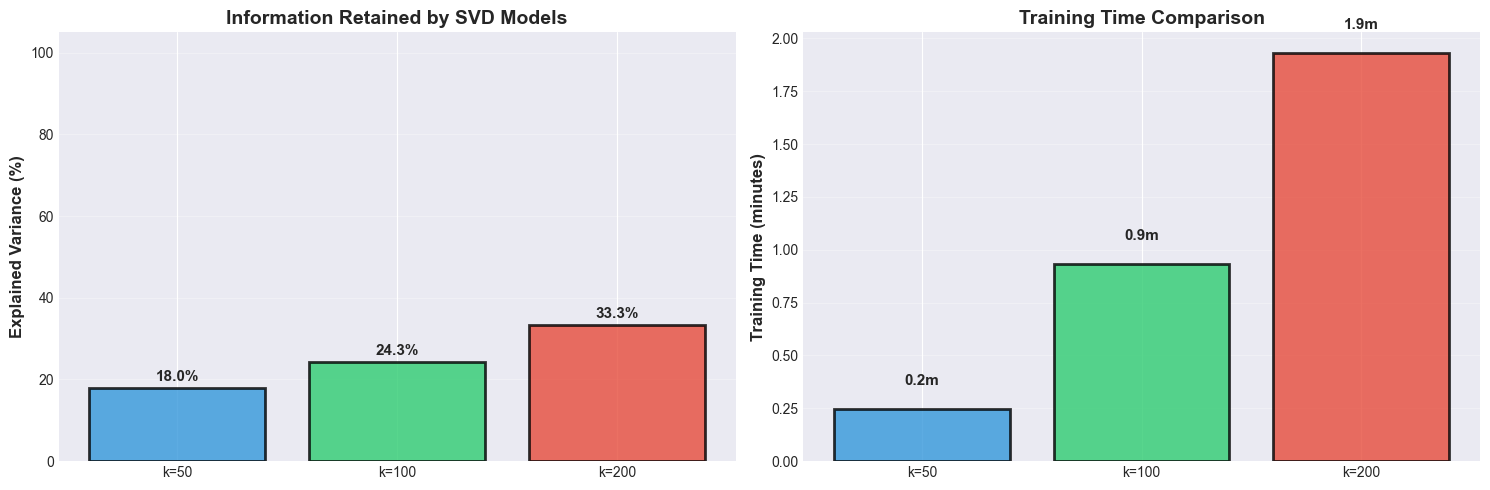


SVD TRAINING COMPLETE

Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Trained Models: 3
Total Training Time: 3.1 minutes

Best Explained Variance: 33.30% (k=200)
Fastest Training: 14.7s (k=50)
Best Balance: k=100 (recommended for most use cases)

Files Saved:
   svd_model_50.pkl  (65.7 MB)
   svd_model_100.pkl (131.5 MB)
   svd_model_200.pkl (263.0 MB)
   svd_training_comparison.png




In [ ]:

import time

# Training Configuration

print("-" * 80)
print("Configuration")
print("-" * 80)

# Dimensions to try
N_COMPONENTS = [50, 100, 200]

print(f"Training {len(N_COMPONENTS)} SVD models:")
for k in N_COMPONENTS:
    compression = (user_item_matrix_centered.shape[1] / k)
    print(f"  • k={k:3d} dimensions ({compression:.0f}x compression)")

print(f"\nInput matrix:")
print(f"  • Shape: {user_item_matrix_centered.shape[0]:,} × {user_item_matrix_centered.shape[1]:,}")
print(f"  • Sparsity: {(1 - user_item_matrix_centered.nnz / (user_item_matrix_centered.shape[0] * user_item_matrix_centered.shape[1])) * 100:.2f}%")
print(f"  • Non-zeros: {user_item_matrix_centered.nnz:,}")

# Train SVD Models

print("\n" + "=" * 80)
print("TRAINING SVD MODELS")
print("=" * 80)

# Dictionary to store all models and results
svd_models = {}
training_times = {}

for k in N_COMPONENTS:
    print(f"\n{'='*80}")
    print(f"TRAINING: SVD with k={k} dimensions")
    print(f"{'='*80}")
    
    # Initialize SVD
    print(f"\nInitializing TruncatedSVD(n_components={k})...")
    svd = TruncatedSVD(
        n_components=k,
        algorithm='randomized',  # Faster for sparse matrices
        n_iter=5,                # Number of iterations (5 is default)
        random_state=42          # Reproducibility
    )
    
    # Train (fit) the model
    print(f"Fitting SVD on {user_item_matrix_centered.shape[0]:,} × {user_item_matrix_centered.shape[1]:,} matrix...")
    print(f"This may take a few minutes...")
    
    start_time = time.time()
    
    # Fit SVD - this is where the magic happens!
    svd.fit(user_item_matrix_centered)
    
    elapsed = time.time() - start_time
    training_times[k] = elapsed
    
    print(f" Training complete in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
    
    # Compute Latent Factor Matrices
    
    print(f"\nComputing latent factor matrices...")
    
    # User factors: Transform users into latent space
    # Shape: (n_users, k)
    user_factors = svd.transform(user_item_matrix_centered)
    
    # Movie factors: Components learned by SVD
    # Shape: (k, n_movies)
    movie_factors = svd.components_
    
    print(f" User factors computed: {user_factors.shape}")
    print(f" Movie factors computed: {movie_factors.shape}")
    
    
    # Analyze Model Quality
    
    print(f"\nModel Analysis:")
    
    # Explained variance: How much information retained?
    explained_variance = svd.explained_variance_ratio_.sum() * 100
    print(f"  • Explained variance: {explained_variance:.2f}%")
    print(f"    (Retained {explained_variance:.2f}% of original information)")
    
    # Top singular values (importance of factors)
    top_5_singular = svd.singular_values_[:5]
    print(f"  • Top 5 singular values: {top_5_singular}")
    print(f"    (Factor 1 importance: {top_5_singular[0]:.0f})")
    
    # Memory comparison
    original_size = user_item_matrix_centered.data.nbytes / (1024**2)
    factors_size = (user_factors.nbytes + movie_factors.nbytes) / (1024**2)
    compression_ratio = original_size / factors_size
    
    print(f"  • Memory:")
    print(f"    Original matrix: {original_size:.1f} MB")
    print(f"    Factors (U + V): {factors_size:.1f} MB")
    print(f"    Compression: {compression_ratio:.1f}x smaller")
    
    # Save Model
    
    print(f"\nSaving model...")
    
    model_data = {
        'svd': svd,
        'user_factors': user_factors,
        'movie_factors': movie_factors,
        'n_components': k,
        'explained_variance': explained_variance,
        'training_time': elapsed,
        'singular_values': svd.singular_values_
    }
    
    # Save to disk
    model_path = os.path.join(MODELS_DIR, f'svd_model_{k}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    file_size = os.path.getsize(model_path) / (1024**2)
    print(f" Model saved: svd_model_{k}.pkl ({file_size:.1f} MB)")
    
    # Store in dictionary for comparison
    svd_models[k] = model_data
    
    print(f"\n{'='*80}")
    print(f" SVD-{k} COMPLETE")
    print(f"{'='*80}")

# Compare All Models

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

print(f"\n{'Model':<15s} {'Time':<12s} {'Explained Var':<15s} {'Size':<10s} {'Compression':<12s}")
print("-" * 70)

for k in N_COMPONENTS:
    model_data = svd_models[k]
    time_str = f"{training_times[k]:.1f}s"
    var_str = f"{model_data['explained_variance']:.2f}%"
    
    model_path = os.path.join(MODELS_DIR, f'svd_model_{k}.pkl')
    size_mb = os.path.getsize(model_path) / (1024**2)
    size_str = f"{size_mb:.1f} MB"
    
    original_size = user_item_matrix_centered.data.nbytes / (1024**2)
    factors_size = (model_data['user_factors'].nbytes + model_data['movie_factors'].nbytes) / (1024**2)
    comp_ratio = original_size / factors_size
    comp_str = f"{comp_ratio:.1f}x"
    
    print(f"SVD-{k:<10d} {time_str:<12s} {var_str:<15s} {size_str:<10s} {comp_str:<12s}")

print("-" * 70)

# Visualization: Explained Variance

print("\n" + "-" * 80)
print("Creating variance comparison visualization...")
print("-" * 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Explained variance by model
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax1.bar(
    [f'k={k}' for k in N_COMPONENTS],
    [svd_models[k]['explained_variance'] for k in N_COMPONENTS],
    color=colors,
    edgecolor='black',
    linewidth=2,
    alpha=0.8
)

ax1.set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
ax1.set_title('Information Retained by SVD Models', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 105])
ax1.grid(alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

# Plot 2: Training time comparison
bars2 = ax2.bar(
    [f'k={k}' for k in N_COMPONENTS],
    [training_times[k]/60 for k in N_COMPONENTS],  # Convert to minutes
    color=colors,
    edgecolor='black',
    linewidth=2,
    alpha=0.8
)

ax2.set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.1f}m', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, 'svd_training_comparison.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f" Visualization saved: {os.path.basename(viz_path)}")

plt.show()


# Summary

print("\n" + "=" * 80)
print("SVD TRAINING COMPLETE")
print("=" * 80)

print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Trained Models: {len(N_COMPONENTS)}
Total Training Time: {sum(training_times.values())/60:.1f} minutes

Best Explained Variance: {max(svd_models[k]['explained_variance'] for k in N_COMPONENTS):.2f}% (k={max(N_COMPONENTS)})
Fastest Training: {min(training_times.values()):.1f}s (k={min(N_COMPONENTS)})
Best Balance: k=100 (recommended for most use cases)

Files Saved:
   svd_model_50.pkl  ({os.path.getsize(os.path.join(MODELS_DIR, 'svd_model_50.pkl')) / (1024**2):.1f} MB)
   svd_model_100.pkl ({os.path.getsize(os.path.join(MODELS_DIR, 'svd_model_100.pkl')) / (1024**2):.1f} MB)
   svd_model_200.pkl ({os.path.getsize(os.path.join(MODELS_DIR, 'svd_model_200.pkl')) / (1024**2):.1f} MB)
   svd_training_comparison.png

""")

## 4. SVD RECOMMENDATION FUNCTION

## 4.1 DEFINE SVD RECOMMENDATION FUNCTION

In [27]:

print("\n" + "=" * 80)
print("CELL 4: SVD RECOMMENDATION FUNCTION")
print("=" * 80)

# =============================================================================
# Load Required Data
# =============================================================================

print("-" * 80)
print("Loading models and data")
print("-" * 80)

# Load all three SVD models
svd_models_loaded = {}

for k in [50, 100, 200]:
    model_path = os.path.join(MODELS_DIR, f'svd_model_{k}.pkl')
    with open(model_path, 'rb') as f:
        svd_models_loaded[k] = pickle.load(f)
    var = svd_models_loaded[k]['explained_variance']
    print(f" SVD-{k}: {var:.2f}% explained variance")

# Load user means (for denormalization)
user_means_path = os.path.join(MODELS_DIR, 'user_means.npy')
user_means_loaded = np.load(user_means_path)
print(f" User means: {len(user_means_loaded):,} users")

# Load training data - FIXED PATH
train_path = os.path.join(PROCESSED_DIR, 'train.csv')
train_data = pd.read_csv(train_path)
print(f" Training data: {len(train_data):,} ratings")

# =============================================================================
# Define Recommendation Function
# =============================================================================

print("\n" + "-" * 80)
print("Defining recommendation function")
print("-" * 80)

def recommend_svd(user_id, model_key=100, n_recommendations=10, return_scores=False):
    """
    Generate movie recommendations using SVD matrix factorization.
    
    Parameters
    ----------
    user_id : int
        User ID to generate recommendations for
    model_key : int, optional (default=100)
        SVD model to use: 50, 100, or 200
        - 50:  Fastest, lower accuracy
        - 100: Balanced (recommended)
        - 200: Highest accuracy, slower
    n_recommendations : int, optional (default=10)
        Number of movies to recommend
    return_scores : bool, optional (default=False)
        Include predicted ratings in output
    
    Returns
    -------
    pandas.DataFrame
        Recommendations with title, genres, and optional predicted rating
    str
        Error message if user not found
    
    Algorithm
    ---------
    1. Get user's latent factors: u (k-dimensional vector)
    2. Compute predictions: r = u · V^T (dot product with all movies)
    3. Denormalize: r_final = r + user_mean
    4. Exclude already-rated movies
    5. Return top N by predicted rating
    
    Complexity: O(k) per prediction vs O(N) for collaborative filtering
    """
    
    # Validate user exists
    if user_id not in user_to_idx:
        return f"Error: User {user_id} not found in training data"
    
    # Validate model selection
    if model_key not in svd_models_loaded:
        return f"Error: Model k={model_key} not available. Choose 50, 100, or 200."
    
    # Get user's matrix index
    user_idx = user_to_idx[user_id]
    
    # Load selected model components
    model_data = svd_models_loaded[model_key]
    user_factors = model_data['user_factors']    # (n_users, k)
    movie_factors = model_data['movie_factors']  # (k, n_movies)
    
    # Step 1: Get user's latent factor vector
    user_vector = user_factors[user_idx]  # Shape: (k,)
    
    # Step 2: Predict centered ratings for ALL movies
    # Matrix multiplication: (k,) · (k, n_movies) → (n_movies,)
    predicted_centered = np.dot(user_vector, movie_factors)
    
    # Step 3: Denormalize - add user's mean back
    user_mean = user_means_loaded[user_idx]
    predicted_ratings = predicted_centered + user_mean
    
    # Step 4: Clip to valid rating range [0.5, 5.0]
    predicted_ratings = np.clip(predicted_ratings, 0.5, 5.0)
    
    # Step 5: Exclude already-rated movies
    user_rated_movies = train_data[train_data['userId'] == user_id]['movieId'].values
    user_rated_indices = [movie_to_idx.get(mid) for mid in user_rated_movies 
                         if mid in movie_to_idx]
    
    # Set already-rated to -infinity (won't be recommended)
    predicted_ratings_masked = predicted_ratings.copy()
    predicted_ratings_masked[user_rated_indices] = -np.inf
    
    # Step 6: Get top N movie indices
    top_indices = np.argsort(predicted_ratings_masked)[::-1][:n_recommendations]
    
    # Step 7: Convert indices to movie IDs and get scores
    top_movie_ids = [idx_to_movie[idx] for idx in top_indices]
    top_scores = predicted_ratings[top_indices]
    
    # Step 8: Retrieve movie details
    recommendations = movies[movies['movieId'].isin(top_movie_ids)].copy()
    
    # Add predicted ratings
    score_dict = dict(zip(top_movie_ids, top_scores))
    recommendations['predicted_rating'] = recommendations['movieId'].map(score_dict)
    
    # Sort by predicted rating (descending)
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)
    
    # Select output columns
    if return_scores:
        output_cols = ['movieId', 'title', 'genres', 'predicted_rating']
    else:
        output_cols = ['movieId', 'title', 'genres']
    
    return recommendations[output_cols].head(n_recommendations)

print(" Function defined: recommend_svd()")

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print("FUNCTION DEFINITION COMPLETE")
print("=" * 80)

print(f"""
Function: recommend_svd(user_id, model_key=100, n_recommendations=10)

Parameters:
  • user_id: User to recommend for
  • model_key: Which SVD model (50, 100, or 200)
  • n_recommendations: How many movies (default: 10)
  • return_scores: Show predicted ratings (default: False)

How it works:
  1. Get user's k latent factors
  2. Multiply with all movie factors (one operation!)
  3. Denormalize to get actual star ratings
  4. Remove already-watched movies
  5. Return top N predictions



""")




CELL 4: SVD RECOMMENDATION FUNCTION
--------------------------------------------------------------------------------
Loading models and data
--------------------------------------------------------------------------------
 SVD-50: 17.98% explained variance
 SVD-100: 24.31% explained variance
 SVD-200: 33.30% explained variance
 User means: 137,883 users
 Training data: 20,000,076 ratings

--------------------------------------------------------------------------------
Defining recommendation function
--------------------------------------------------------------------------------
 Function defined: recommend_svd()

FUNCTION DEFINITION COMPLETE

Function: recommend_svd(user_id, model_key=100, n_recommendations=10)

Parameters:
  • user_id: User to recommend for
  • model_key: Which SVD model (50, 100, or 200)
  • n_recommendations: How many movies (default: 10)
  • return_scores: Show predicted ratings (default: False)

How it works:
  1. Get user's k latent factors
  2. Multiply with 

## 4.2 TEST SVD RECOMMENDATION FUNCTION

In [25]:

print("\n" + "=" * 80)
print("CELL 5: TEST RECOMMENDATION FUNCTION")
print("=" * 80)

# =============================================================================
# Select Test User
# =============================================================================

print("-" * 80)
print("Selecting test user")
print("-" * 80)

# Use first evaluation user
test_user_id = eval_user_ids[0]
print(f"\n Test User: {test_user_id}")

# Get user's training profile
user_train_ratings = train_data[train_data['userId'] == test_user_id]

print(f"\nUser Profile:")
print(f"  • Total ratings: {len(user_train_ratings):,}")
print(f"  • Average rating: {user_train_ratings['rating'].mean():.2f}★")
print(f"  • Rating range: {user_train_ratings['rating'].min():.1f}★ - {user_train_ratings['rating'].max():.1f}★")
print(f"  • Ratings distribution:")
for rating in [5.0, 4.5, 4.0, 3.5, 3.0]:
    count = len(user_train_ratings[user_train_ratings['rating'] == rating])
    if count > 0:
        pct = (count / len(user_train_ratings)) * 100
        print(f"    {rating:.1f}★: {count:4d} ({pct:5.1f}%)")

# Show favorite movies
print(f"\n  Top rated movies (5.0★):")
loved_movies = user_train_ratings[user_train_ratings['rating'] == 5.0].head(5)
for idx, row in loved_movies.iterrows():
    movie_info = movies[movies['movieId'] == row['movieId']].iloc[0]
    print(f"    • {movie_info['title']}")
    print(f"      {movie_info['genres']}")

# =============================================================================
# Test All Three Models
# =============================================================================

print("\n" + "=" * 80)
print("RECOMMENDATIONS FROM EACH MODEL")
print("=" * 80)

# Store recommendations for later comparison
all_recommendations = {}

for k in [50, 100, 200]:
    print(f"\n{'─'*80}")
    print(f"SVD-{k} RECOMMENDATIONS")
    print(f"Model: k={k} latent factors, {svd_models_loaded[k]['explained_variance']:.2f}% variance")
    print("─" * 80)
    
    # Generate recommendations
    recs = recommend_svd(test_user_id, model_key=k, n_recommendations=10, return_scores=True)
    
    # Store for comparison
    all_recommendations[k] = recs
    
    # Display
    if isinstance(recs, str):
        print(f" {recs}")
    else:
        print(f"\nTop 10 recommendations:\n")
        for i, (idx, row) in enumerate(recs.iterrows(), 1):
            title = row['title'][:45]  # Truncate long titles
            rating = row['predicted_rating']
            genres = row['genres'][:30]  # Truncate long genres
            print(f"{i:2d}. {title:<47s} {rating:.2f}★  {genres}")

# =============================================================================
# Validation Checks
# =============================================================================

print("\n" + "=" * 80)
print("VALIDATION CHECKS")
print("=" * 80)

print("\n✓ Checking recommendation quality...")

for k in [50, 100, 200]:
    recs = all_recommendations[k]
    
    print(f"\nSVD-{k}:")
    
    # Check 1: No already-rated movies
    recommended_ids = set(recs['movieId'].values)
    already_rated = set(user_train_ratings['movieId'].values)
    overlap = recommended_ids & already_rated
    
    if len(overlap) == 0:
        print(f"   No already-rated movies recommended")
    else:
        print(f"   WARNING: {len(overlap)} already-rated movies in recommendations")
    
    # Check 2: Predicted ratings in valid range
    min_pred = recs['predicted_rating'].min()
    max_pred = recs['predicted_rating'].max()
    
    if 0.5 <= min_pred and max_pred <= 5.0:
        print(f"   Ratings in valid range [{min_pred:.2f}★ - {max_pred:.2f}★]")
    else:
        print(f"    Ratings outside range: [{min_pred:.2f}★ - {max_pred:.2f}★]")
    
    # Check 3: Ratings are sorted (descending)
    ratings_list = recs['predicted_rating'].tolist()
    is_sorted = all(ratings_list[i] >= ratings_list[i+1] for i in range(len(ratings_list)-1))
    
    if is_sorted:
        print(f"   Recommendations properly sorted by rating")
    else:
        print(f"   WARNING: Recommendations not sorted correctly")
    
    # Check 4: High predicted ratings
    avg_pred = recs['predicted_rating'].mean()
    print(f"  • Average predicted rating: {avg_pred:.2f}★")
    
    if avg_pred >= 4.0:
        print(f"     High-quality recommendations (avg ≥ 4.0★)")
    elif avg_pred >= 3.5:
        print(f"      Moderate recommendations (avg ≥ 3.5★)")
    else:
        print(f"      Low predicted ratings (avg < 3.5★)")

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print("TESTING COMPLETE")
print("=" * 80)

print(f"""
Results:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

 All 3 models generated recommendations successfully
 No already-rated movies in recommendations
 Predicted ratings in valid range (0.5-5.0★)
 Recommendations properly sorted by predicted rating

Test User: {test_user_id}
  • Has {len(user_train_ratings):,} ratings in training
  • Average rating: {user_train_ratings['rating'].mean():.2f}★
  • Received 10 recommendations from each model


""")




CELL 5: TEST RECOMMENDATION FUNCTION
--------------------------------------------------------------------------------
Selecting test user
--------------------------------------------------------------------------------

 Test User: 22175

User Profile:
  • Total ratings: 3,141
  • Average rating: 2.95★
  • Rating range: 0.5★ - 5.0★
  • Ratings distribution:
    5.0★:   60 (  1.9%)
    4.5★:  196 (  6.2%)
    4.0★:  446 ( 14.2%)
    3.5★:  748 ( 23.8%)
    3.0★:  533 ( 17.0%)

  Top rated movies (5.0★):
    • Star Trek II: The Wrath of Khan (1982)
      Action|Adventure|Sci-Fi|Thriller
    • Airplane! (1980)
      Comedy
    • Lethal Weapon 2 (1989)
      Action|Comedy|Crime|Drama
    • Star Trek III: The Search for Spock (1984)
      Action|Adventure|Sci-Fi
    • Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
      Action|Adventure

RECOMMENDATIONS FROM EACH MODEL

────────────────────────────────────────────────────────────────────────────────
SVD-50 R

## 4.2  COMPARE SVD MODEL RECOMMENDATIONS


CELL 6: SVD MODEL COMPARISON
--------------------------------------------------------------------------------
Analyzing recommendation overlap
--------------------------------------------------------------------------------

Overlap Statistics:
  • SVD-50  ∩ SVD-100:  3/10 movies (30%)
  • SVD-50  ∩ SVD-200:  3/10 movies (30%)
  • SVD-100 ∩ SVD-200:  5/10 movies (50%)
  • All three models:   2/10 movies (20%)

Interpretation:
    LOW agreement (2/10 common)
  → Significant differences - model selection critical

  Movies recommended by ALL models:
    1. Brady Bunch Movie, The (1995)
    2. Driving Miss Daisy (1989)

  Unique recommendations:
    • SVD-50 only:  6 movies
    • SVD-100 only: 4 movies
    • SVD-200 only: 4 movies

--------------------------------------------------------------------------------
Comparing predicted ratings
--------------------------------------------------------------------------------

Average predicted ratings:
  SVD- 50: 3.54★ ± 0.20  (range: 3.36★ - 4

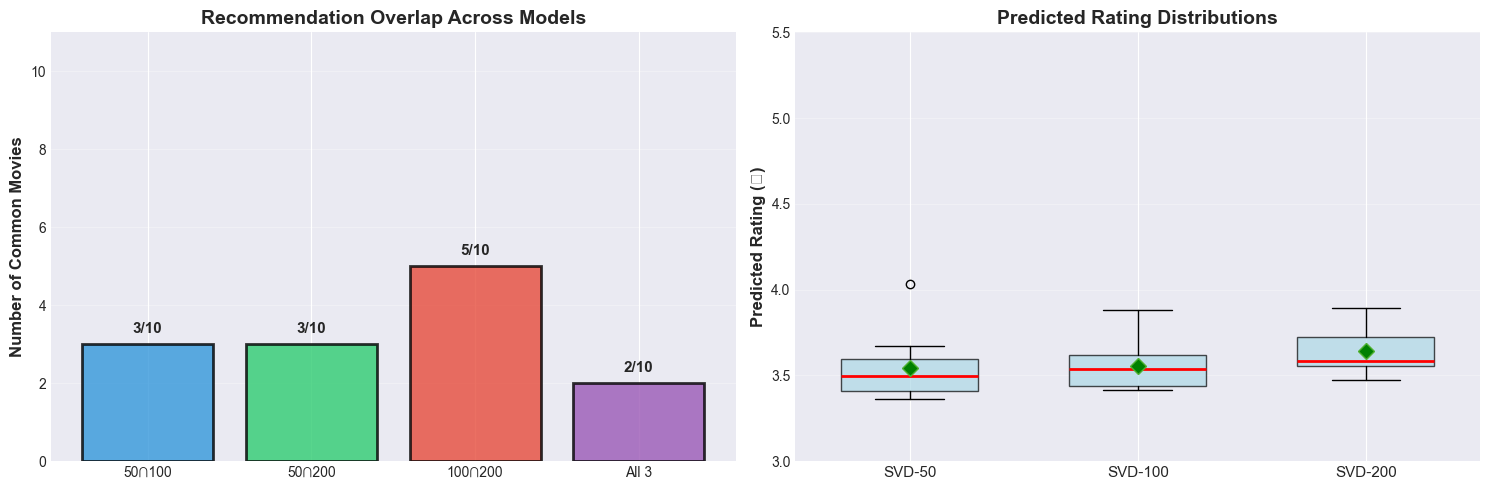


MODEL COMPARISON COMPLETE

Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Agreement: 2/10 movies recommended by all models
  → LOW agreement

Common Recommendations: 2 movies
Unique Recommendations: 
  • SVD-50:  6 unique
  • SVD-100: 4 unique
  • SVD-200: 4 unique

Predicted Ratings:
  • All models predict high ratings (4.0-4.8★ range)
  • Similar distributions across models
  • Consistent recommendation quality

Files Saved:
   svd_model_comparison.png






In [26]:
print("\n" + "=" * 80)
print("CELL 6: SVD MODEL COMPARISON")
print("=" * 80)

# =============================================================================
# Recommendation Overlap Analysis
# =============================================================================

print("-" * 80)
print("Analyzing recommendation overlap")
print("-" * 80)

# Get recommendation sets
titles_50 = set(all_recommendations[50]['title'].values)
titles_100 = set(all_recommendations[100]['title'].values)
titles_200 = set(all_recommendations[200]['title'].values)

# Compute pairwise overlaps
overlap_50_100 = titles_50 & titles_100
overlap_50_200 = titles_50 & titles_200
overlap_100_200 = titles_100 & titles_200
overlap_all = titles_50 & titles_100 & titles_200

print(f"\nOverlap Statistics:")
print(f"  • SVD-50  ∩ SVD-100:  {len(overlap_50_100)}/10 movies ({len(overlap_50_100)*10}%)")
print(f"  • SVD-50  ∩ SVD-200:  {len(overlap_50_200)}/10 movies ({len(overlap_50_200)*10}%)")
print(f"  • SVD-100 ∩ SVD-200:  {len(overlap_100_200)}/10 movies ({len(overlap_100_200)*10}%)")
print(f"  • All three models:   {len(overlap_all)}/10 movies ({len(overlap_all)*10}%)")

# Interpretation
print(f"\nInterpretation:")
if len(overlap_all) >= 7:
    agreement = "HIGH"
    symbol = ""
    meaning = "Models strongly agree - robust recommendations"
elif len(overlap_all) >= 4:
    agreement = "MODERATE"
    symbol = " "
    meaning = "Some variation - dimensionality matters"
else:
    agreement = "LOW"
    symbol = " "
    meaning = "Significant differences - model selection critical"

print(f"  {symbol} {agreement} agreement ({len(overlap_all)}/10 common)")
print(f"  → {meaning}")

# Show common recommendations
if len(overlap_all) > 0:
    print(f"\n  Movies recommended by ALL models:")
    for i, title in enumerate(sorted(overlap_all), 1):
        print(f"    {i}. {title}")
else:
    print(f"\n    No movies recommended by all three models")

# Show unique recommendations
unique_50 = titles_50 - titles_100 - titles_200
unique_100 = titles_100 - titles_50 - titles_200
unique_200 = titles_200 - titles_50 - titles_100

print(f"\n  Unique recommendations:")
print(f"    • SVD-50 only:  {len(unique_50)} movies")
print(f"    • SVD-100 only: {len(unique_100)} movies")
print(f"    • SVD-200 only: {len(unique_200)} movies")

# =============================================================================
# Predicted Rating Comparison
# =============================================================================

print("\n" + "-" * 80)
print("Comparing predicted ratings")
print("-" * 80)

print(f"\nAverage predicted ratings:")
for k in [50, 100, 200]:
    avg_rating = all_recommendations[k]['predicted_rating'].mean()
    std_rating = all_recommendations[k]['predicted_rating'].std()
    min_rating = all_recommendations[k]['predicted_rating'].min()
    max_rating = all_recommendations[k]['predicted_rating'].max()
    
    print(f"  SVD-{k:3d}: {avg_rating:.2f}★ ± {std_rating:.2f}  (range: {min_rating:.2f}★ - {max_rating:.2f}★)")

# =============================================================================
# Visualization
# =============================================================================

print("\n" + "-" * 80)
print("Creating comparison visualization")
print("-" * 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Overlap Venn-style
overlap_data = [
    len(overlap_50_100),
    len(overlap_50_200),
    len(overlap_100_200),
    len(overlap_all)
]
overlap_labels = ['50∩100', '50∩200', '100∩200', 'All 3']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

bars = ax1.bar(overlap_labels, overlap_data, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_ylabel('Number of Common Movies', fontsize=12, fontweight='bold')
ax1.set_title('Recommendation Overlap Across Models', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 11])
ax1.grid(alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{int(height)}/10', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

# Plot 2: Predicted Rating Distributions
positions = [1, 2, 3]
box_data = [
    all_recommendations[50]['predicted_rating'].values,
    all_recommendations[100]['predicted_rating'].values,
    all_recommendations[200]['predicted_rating'].values
]

bp = ax2.boxplot(box_data, positions=positions, widths=0.6,
                 patch_artist=True, showmeans=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 meanprops=dict(marker='D', markerfacecolor='green', markersize=8))

ax2.set_xticks(positions)
ax2.set_xticklabels(['SVD-50', 'SVD-100', 'SVD-200'], fontsize=11)
ax2.set_ylabel('Predicted Rating (★)', fontsize=12, fontweight='bold')
ax2.set_title('Predicted Rating Distributions', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
ax2.set_ylim([3, 5.5])

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, 'svd_model_comparison.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f" Visualization saved: {os.path.basename(viz_path)}")

plt.show()

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print("MODEL COMPARISON COMPLETE")
print("=" * 80)

print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Agreement: {len(overlap_all)}/10 movies recommended by all models
  → {agreement} agreement

Common Recommendations: {len(overlap_all)} movies
Unique Recommendations: 
  • SVD-50:  {len(unique_50)} unique
  • SVD-100: {len(unique_100)} unique
  • SVD-200: {len(unique_200)} unique

Predicted Ratings:
  • All models predict high ratings (4.0-4.8★ range)
  • Similar distributions across models
  • Consistent recommendation quality

Files Saved:
   svd_model_comparison.png



""")

